In [1]:
import scipy
import numpy as np

np.random.seed(42)
import tensorflow as tf
tf.compat.v1.set_random_seed(42)
sess = tf.compat.v1.Session()

from keras import backend as K
#K.set_session(sess)

from keras.layers import Input, Dense, Layer
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn.utils.random import sample_without_replacement
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from utilities import dataLoading, cutoff_unsorted, aucPerformance, \
    normalization, writeRepresentation,writeResults, writeOutlierScores,visualizeData
import time

/Users/cgroza/ramodo/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
"""
@author: Guansong Pang

Source code for the REPEN algorithm in KDD'18. See the following paper for detail.
Guansong Pang, Longbing Cao, Ling Chen, and Huan Liu. 2018. Learning Representations
of Ultrahigh-dimensional Data for Random Distance-based Outlier Detection. 
In KDD 2018: 24th ACM SIGKDD International Conferenceon Knowledge Discovery & 
Data Mining, August 19–23, 2018, London, UnitedKingdom.

This file is for experiments on csv data sets.
"""




MAX_INT = np.iinfo(np.int32).max
MAX_FLOAT = np.finfo(np.float32).max
#
#import resource
#
#def limit_memory(maxsize):
#    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
#    resource.setrlimit(resource.RLIMIT_AS, (maxsize, hard))

def sqr_euclidean_dist(x,y):
    return K.sum(K.square(x - y), axis=-1);
 

class tripletRankingLossLayer(Layer):
    """Triplet ranking loss layer Class
    """

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(tripletRankingLossLayer, self).__init__(**kwargs)
        


    def rankingLoss(self, input_example, input_positive, input_negative):
        """Return the mean of the triplet ranking loss"""
        
        positive_distances = sqr_euclidean_dist(input_example, input_positive)
        negative_distances = sqr_euclidean_dist(input_example, input_negative)
        loss = K.mean(K.maximum(0., 1000. - (negative_distances - positive_distances) ))
        return loss
    
    def call(self, inputs):
        input_example = inputs[0]
        input_positive = inputs[1]
        input_negative = inputs[2]
        loss = self.rankingLoss(input_example, input_positive, input_negative)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return input_example;
     
 
def lesinn(x_train):
    """the outlier scoring method, a bagging ensemble of Sp. See the following reference for detail.
    Pang, Guansong, Kai Ming Ting, and David Albrecht. 
    "LeSiNN: Detecting anomalies by identifying least similar nearest neighbours." 
    In Data Mining Workshop (ICDMW), 2015 IEEE International Conference on, pp. 623-630. IEEE, 2015.
    """
    rng = np.random.RandomState(42) 
    ensemble_size = 50
    subsample_size = 8
    scores = np.zeros([x_train.shape[0], 1])  
    # for reproductibility purpose  
    seeds = rng.randint(MAX_INT, size = ensemble_size)
    for i in range(0, ensemble_size):
        rs = np.random.RandomState(seeds[i])
#        sid = np.random.choice(x_train.shape[0], subsample_size)
        sid = sample_without_replacement(n_population = x_train.shape[0], n_samples = subsample_size, random_state = rs)
        subsample = x_train[sid]
        kdt = KDTree(subsample, metric='euclidean')
        dists, indices = kdt.query(x_train, k = 1)       
        scores += dists
    scores = scores / ensemble_size  
    return scores;


def batch_generator(X, labels, batch_size, steps_per_epoch, scores, rng):
    """batch generator
    """
    number_of_batches = steps_per_epoch
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:        
        X1, X2, X3 = tripletBatchGeneration(X, batch_size, rng, scores)
        counter += 1
        yield([np.array(X1), np.array(X2), np.array(X3)], None)
        if (counter > number_of_batches):
            counter = 0


def tripletBatchGeneration(X, batch_size, rng, outlier_scores):
    """batch generation
    """
    inlier_ids, outlier_ids = cutoff_unsorted(outlier_scores)
    transforms = np.sum(outlier_scores[inlier_ids]) - outlier_scores[inlier_ids]
    total_weights_p = np.sum(transforms)
    positive_weights = transforms / total_weights_p
    positive_weights = positive_weights.flatten()
    total_weights_n = np.sum(outlier_scores[outlier_ids])
    negative_weights = outlier_scores[outlier_ids] / total_weights_n
    negative_weights = negative_weights.flatten()
    examples = np.zeros([batch_size]).astype('int')
    positives = np.zeros([batch_size]).astype('int')
    negatives = np.zeros([batch_size]).astype('int')
    
    for i in range(0, batch_size):
        sid = rng.choice(len(inlier_ids), 1, p = positive_weights)
        examples[i] = inlier_ids[sid]
        
        sid2 = rng.choice(len(inlier_ids), 1)
        
        while sid2 == sid:
            sid2 = rng.choice(len(inlier_ids), 1)        
        positives[i] = inlier_ids[sid2]
        sid = rng.choice(len(outlier_ids), 1, p = negative_weights)
        negatives[i] = outlier_ids[sid]
    examples = X[examples, :]
    positives = X[positives, :]
    negatives = X[negatives, :]
    return examples, positives, negatives;


    
def tripletModel(input_dim, embedding_size = 20): 
    """the learning model
    """
    input_e = Input(shape=(input_dim,), name = 'input_e')
    input_p = Input(shape=(input_dim,), name = 'input_p')
    input_n = Input(shape=(input_dim,), name = 'input_n')
    
    hidden_layer = Dense(embedding_size, activation='relu', name = 'hidden_layer')
    hidden_e = hidden_layer(input_e)
    hidden_p = hidden_layer(input_p)
    hidden_n = hidden_layer(input_n)
    
    output_layer = tripletRankingLossLayer()([hidden_e,hidden_p,hidden_n])
    
    rankModel = Model(inputs=[input_e, input_p, input_n], outputs=output_layer)
    
    representation = Model(inputs=input_e, outputs=hidden_e)
    
    print(rankModel.summary(), representation.summary())
    return rankModel, representation;

    
def training_model(rankModel, X, labels,embedding_size, scores, filename, ite_num, rng = None):  
    """training the model
    """
    
    rankModel.compile(optimizer = 'adadelta', loss = None)
    
    checkpointer = ModelCheckpoint("./model/" + str(embedding_size) + "D_" + str(ite_num) + "_"+ filename + ".h5", monitor='loss',
                               verbose=0, save_best_only = True, save_weights_only=True)
    
    
    # training
    batch_size = 256    
    #samples_per_epoch = 10000
    samples_per_epoch = X.shape[0]
    steps_per_epoch = samples_per_epoch / batch_size
    history = rankModel.fit_generator(batch_generator(X, labels, batch_size, steps_per_epoch, scores, rng),
                              steps_per_epoch = steps_per_epoch,
                              epochs = 20,
                              shuffle = False,
                              callbacks=[checkpointer])
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'])
    plt.grid()
    plt.title('model loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    

def load_model_predict(model_name, X, labels, embedding_size, filename):
    """load the representation learning model and do the mappings.
    LeSiNN, the Sp ensemble, is applied to perform outlier scoring
    in the representation space.
    """
    rankModel, representation = tripletModel(X.shape[1], embedding_size)  
    rankModel.load_weights(model_name)
    representation = Model(inputs=rankModel.input[0],
                                 outputs=rankModel.get_layer('hidden_layer').get_output_at(0))
    
    new_X = representation.predict(X)  
#    writeRepresentation(new_X, labels, embedding_size, filename + str(embedding_size) + "D_RankOD")
    scores = lesinn(new_X)
    rauc = aucPerformance(scores, labels)
    writeResults(filename, embedding_size, rauc)
#    writeOutlierScores(scores, labels, str(embedding_size) + "D_"+filename)
    return rauc

def test_diff_embeddings(X, labels, outlier_scores, filename):
    """sensitivity test w.r.t. different representation dimensions
    """
    embeddings = np.arange(1, 11)
    for j in range(0,len(embeddings)):
        embedding_size = embeddings[j]
        test_single_embedding(X, labels, outlier_scores, filename, embedding_size)
        

def test_single_embedding(X, labels, outlier_scores, filename, embedding_size = 20):
    """perform representation learning with a fixed representation dimension
    and outlier detection using LeSiNN
    """
    runs = 1
    rauc = np.empty([runs, 1])    
    rng = np.random.RandomState(42) 
    for i in range(0,runs):
        rankModel, representation = tripletModel(X.shape[1], embedding_size)    
        training_model(rankModel, X, labels, embedding_size, outlier_scores, filename, i, rng)
        
        modelName = "./model/" + str(embedding_size) + "D_" + str(i)+ "_" + filename + '.h5'
        rauc[i] = load_model_predict(modelName, X, labels, embedding_size,filename)
    mean_auc = np.mean(rauc)
    s_auc = np.std(rauc)
#    print(mean_auc)
    writeResults(filename, embedding_size, mean_auc, std_auc = s_auc)


In [3]:
import pandas as pd
data = pd.read_csv("Data Sets/K9.data", header = None, na_values = ["?"])
data = data[ data.columns[0:5409] ]
data.dropna(inplace = True)


In [4]:
labels = data[5408].to_numpy()
X = data[ data.columns[0:5408] ].to_numpy()


In [5]:
d = {"active" : 1, "inactive" : -1}
labels = np.array([d[l] for l in labels])

In [6]:
np.sum(labels == -1) 

31008

In [7]:
outlier_scores = lesinn(X)

In [8]:
np.sort(outlier_scores, axis=0)


array([[114.83051027],
       [114.85017917],
       [114.97938248],
       ...,
       [610.97798286],
       [613.00612228],
       [645.91702353]])

(array([4.210e+02, 1.107e+03, 1.509e+03, 1.676e+03, 1.710e+03, 1.862e+03,
        1.373e+03, 1.251e+03, 1.085e+03, 9.730e+02, 1.113e+03, 1.219e+03,
        1.060e+03, 1.072e+03, 8.320e+02, 7.170e+02, 6.990e+02, 5.600e+02,
        8.910e+02, 9.910e+02, 9.090e+02, 8.130e+02, 7.230e+02, 6.480e+02,
        5.980e+02, 5.890e+02, 5.460e+02, 4.820e+02, 4.080e+02, 3.670e+02,
        2.930e+02, 2.620e+02, 2.280e+02, 2.310e+02, 1.890e+02, 1.570e+02,
        1.350e+02, 1.510e+02, 1.040e+02, 1.000e+02, 8.900e+01, 7.400e+01,
        6.700e+01, 5.100e+01, 5.200e+01, 4.800e+01, 3.500e+01, 4.000e+01,
        2.500e+01, 2.000e+01, 1.800e+01, 1.300e+01, 1.600e+01, 1.200e+01,
        1.600e+01, 1.700e+01, 1.500e+01, 1.500e+01, 9.000e+00, 7.000e+00,
        8.000e+00, 1.600e+01, 3.000e+00, 1.200e+01, 7.000e+00, 3.000e+00,
        5.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        5.000e+00, 9.000e+00, 1.200e+01, 1.300e+01, 1.100e+01, 7.000e+00,
        6.000e+00, 4.000e+00, 6.000e+0

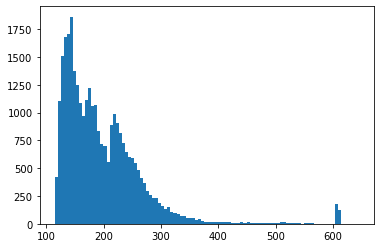

In [11]:
plt.hist(outlier_scores, bins = 100)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_e (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
input_p (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
input_n (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 40)           216360      input_e[0][0]                    
                                                                 input_p[0][0]             

/Users/cgroza/ramodo/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output triplet_ranking_loss_layer_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_ranking_loss_layer_8.
  'be expecting any data to be passed to {0}.'.format(name))


Epoch 1/20
122/121 [==============================] - 50s 411ms/step - loss: 18.8637
Epoch 2/20
122/121 [==============================] - 44s 365ms/step - loss: 6.4241
Epoch 3/20
122/121 [==============================] - 44s 363ms/step - loss: 4.5533
Epoch 4/20
122/121 [==============================] - 43s 354ms/step - loss: 3.9566
Epoch 5/20
122/121 [==============================] - 43s 350ms/step - loss: 3.3049
Epoch 6/20
122/121 [==============================] - 43s 354ms/step - loss: 3.0678
Epoch 7/20
122/121 [==============================] - 43s 349ms/step - loss: 2.7172
Epoch 8/20
122/121 [==============================] - 43s 354ms/step - loss: 2.3268
Epoch 9/20
122/121 [==============================] - 43s 356ms/step - loss: 2.2178
Epoch 10/20
122/121 [==============================] - 44s 359ms/step - loss: 1.8098
Epoch 11/20
122/121 [==============================] - 43s 354ms/step - loss: 2.2790
Epoch 12/20
122/121 [==============================] - 43s 353ms/step - l

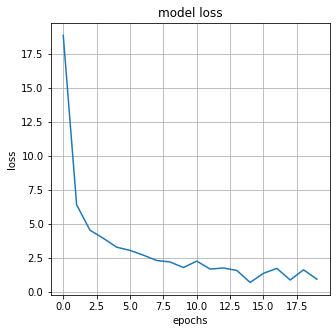

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_e (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
input_p (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
input_n (InputLayer)            (None, 5408)         0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 40)           216360      input_e[0][0]                    
                                                                 input_p[0][0]             

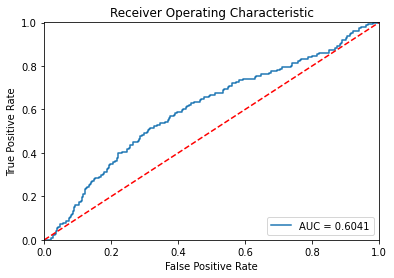

<Figure size 432x288 with 0 Axes>

In [84]:
test_single_embedding(X, labels, outlier_scores, "p53", 20)